# COUGH FEATURE ANALYSIS

In [108]:
import pandas as pd
import numpy as np
import glob
import pickle

#the ids of the coughs-deep.wave
pid_list = glob.glob('positiveaudio/*')
#coughwavefiles
pwavefile_list=[]
for ids in pid_list:
    pwavefile_list = pwavefile_list + [ids+'/cough-heavy.wav']

pjson_id = glob.glob('positive/*')
pjson_list = []
for ji in pjson_id:
    pjson_list=pjson_list + [ji+'/cough-heavy_v2.json']

nid_list = glob.glob('negativeaudio/*')
#coughwavefiles
nwavefile_list=[]
for ids in nid_list:
    nwavefile_list = nwavefile_list + [ids+'/cough-heavy.wav']
njson_id = glob.glob('negative/*')
njson_list = []
for ji in njson_id:
    njson_list=njson_list + [ji+'/cough-heavy_v2.json']

with open('positiveids.txt', 'wb') as pi:
    pickle.dump(pid_list,pi)
with open('negativeids.txt', 'wb') as ri:
    pickle.dump(nid_list, ri)


In [109]:
import os
import pandas as pd
file_list = glob.glob('both/*')
id_list = []
for file in file_list:
    id_list = id_list + [os.path.basename(file)]
#coughwavefiles
wavefile_list=[]
for ids in id_list:
    wavefile_list = wavefile_list + ['bothaudio/'+ids+'/cough-heavy.wav']

json_list = []
for ji in id_list:
    json_list=json_list + ['both/'+ji+'/cough-heavy_v2.json']
    
with open('ids.txt', 'wb') as i:
    pickle.dump(id_list, i)



In [110]:
import json as js  
metadata = []
for ids in id_list:
    metadata = metadata + ['bothaudio/'+ids+'/metadata.json']
with open('meadatapaths.txt', 'wb') as md:
    pickle.dump(metadata, md)

        
        
df = pd.DataFrame(columns=['ID','gender','age','status','number of cycles','mean duration','avg time between cycles'])
df['ID'] = id_list
for jl in range(len(metadata)):
    with open(metadata[jl]) as jsonfile:
        data = js.load(jsonfile)
    df['gender'][jl] = data['g']
    df['age'][jl] = data['a']
    if(data['covid_status'] == 'healthy'):
        df['status'][jl] = 'non_covid'
    elif(data['covid_status'] == 'resp_illness_not_identified'):
        df['status'][jl] = 'non_covid'
    elif(data['covid_status'] == 'no_resp_illness_exposed'):
        df['status'][jl] = 'non_covid'
    else:
        df['status'][jl] = 'covid'    
        
df['status'].value_counts()   

    

non_covid    80
covid        20
Name: status, dtype: int64

100 cough files are chosen that are reasonably clean. 80 non-covid and 20 covid cough samples are chosen. Four physical aspects of this data is introspected.They are:-
1)age   
2)number of cough cycles per file (3 was asked of the patients, but there has been variations).    
3)Duration of each cough cycle in covid and non-covid 
4)Average duration between cough cycles for each ID. (In rare cases wherein only 1 cough bout has been detected, (such files being smaller than the usual), it is presumed that the next cycle is just after the end of the audio, and hence the average duration is length_of_audio_file-end_boundary

In [111]:
import librosa
for jl in range(len(json_list)):
    with open(json_list[jl]) as jsonfile:
        data = js.load(jsonfile)
    del data['vol']
    del data['stage']
    del data['cont']
    del data['annotator_name']
    del data['quality']
    avg = 0
    df['number of cycles'][jl]  = int(len(data)/2)
    
    for l in range(int(len(data)/2)):
        avg = (avg + (data['end_{}'.format(l+1)]-data['start_{}'.format(l+1)]))/2
    df['mean duration'][jl] = avg
    
    
    y,sr = librosa.load(wavefile_list[jl], sr = 16000)
    dur = librosa.get_duration(y=y, sr = sr)


    mean_time_between_cycles = 0
    if(df['number of cycles'][jl] > 1):
        for l in range(int(len(data)/2)-1):
            mean_time_between_cycles = (mean_time_between_cycles + (data['start_{}'.format(l+2)]-data['end_{}'.format(l+1)]))/2
    else:
        mean_time_between_cycles = dur - data['end_{}'.format(l+1)]          
    
    df['avg time between cycles'][jl] = mean_time_between_cycles

In [112]:
df.to_csv('cough_params.csv')
df.head()

,ID,gender,age,status,number of cycles,mean duration,avg time between cycles
0,IkdWn0v3dAU9eWzsf3rY8Dwgf0V2,female,20,covid,1,0.6605,0.208375
1,iu13CF47sRTOnPlhkzTszNkqAZ83,male,29,non_covid,3,0.42,0.18775
2,VB3X18XtrRdSVJ8zDzdyKohlX2F2,female,29,non_covid,8,0.432094,0.425813
3,lzB1CcCk33VjfRiW9vbXkplPO0r1,female,23,non_covid,6,0.463938,0.315594
4,uHPhyLsj5eYghJQOYj7iXa0fyOE3,male,30,non_covid,5,0.409156,0.771062


In [113]:
params = df.columns
params

Index(['ID', 'gender', 'age', 'status', 'number of cycles', 'mean duration',
       'avg time between cycles'],
      dtype='object')

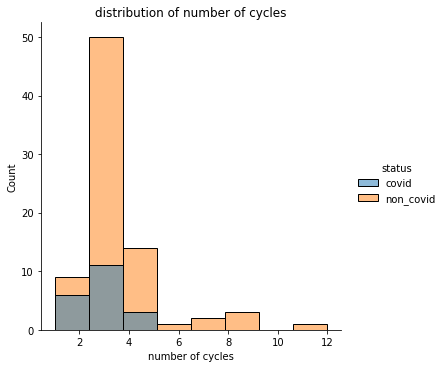

In [150]:
#distribution of number of cycles
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data = df, x = 'number of cycles', kind ="hist", hue = 'status')

plt.title('distribution of number of cycles')
plt.savefig('numcycles.png')

As we can see, most of the recorded data(61) have 3 cycles per files. But there are outliers towards 1 cycle and 12 cycle. The covid positive data in these 100 samples closely follows the non-covid distribution, having considerable amount of data in 1/2 samples.

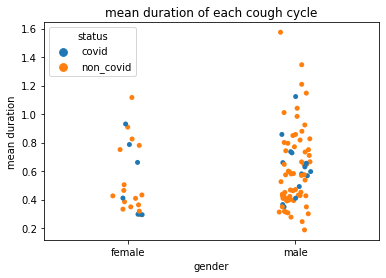

In [42]:
#distribution 
import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(data = df, x = 'gender',y = 'mean duration', hue = 'status')
plt.title('mean duration of each cough cycle')
plt.savefig('meandurationofeachcycle.png')


The plot of mean duration of each cough cycle between male and female. 

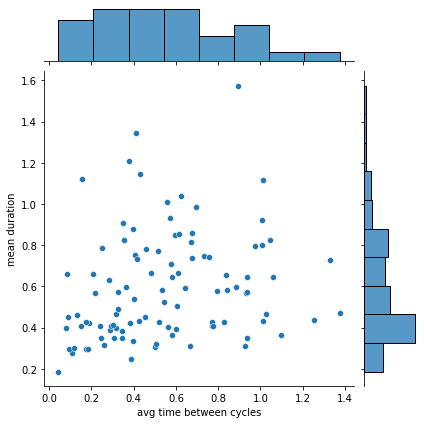

In [59]:
#distribution 
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(data = df, x = 'avg time between cycles',y = 'mean duration')
#plt.title('relation between mean duration of each cough cycle to avg time between them.')
plt.savefig('meandurationofeachcycle.png')


In [147]:
df['age'] = df.age.astype(int)
df['number of cycles'] = df["number of cycles"].astype(float)
df['mean duration'] = df["mean duration"].astype(float)
df['avg time between cycles'] = df["avg time between cycles"].astype(float)
df['status'] = df["status"].astype('str')
df['gender'] = df["gender"].astype('str')


df.dtypes


ID                          object
gender                      object
age                          int64
status                      object
number of cycles           float64
mean duration              float64
avg time between cycles    float64
dtype: object

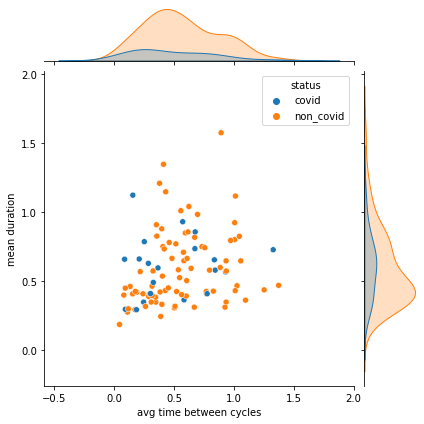

In [102]:
#distribution 
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(data = df, x = 'avg time between cycles',y = 'mean duration', hue = 'status')
plt.savefig('huestatus.png')

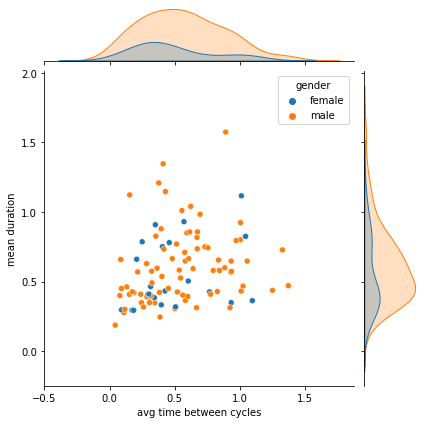

In [105]:
#distribution 
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(data = df, x = 'avg time between cycles',y = 'mean duration', hue = 'gender')
plt.savefig('huegender.png')

The above two plots show that there is some marginal correlation between the two variables that describe average time bewteen cough cycles and mean duration between cough cycles

In [106]:
df.describe()

,age,number of cycles,mean duration,avg time between cycles
count,100.000000,100.000000,100.000000,100.000000
mean,32.520000,3.410000,0.593892,0.545423
std,11.308779,1.621167,0.261956,0.310578
min,14.000000,1.000000,0.186625,0.043500
25%,24.750000,3.000000,0.406688,0.313695
50%,30.000000,3.000000,0.551875,0.511125
75%,37.250000,3.000000,0.750031,0.769328
max,70.000000,12.000000,1.574250,1.374000


The statistics of the basic parameters considered.

<AxesSubplot:>

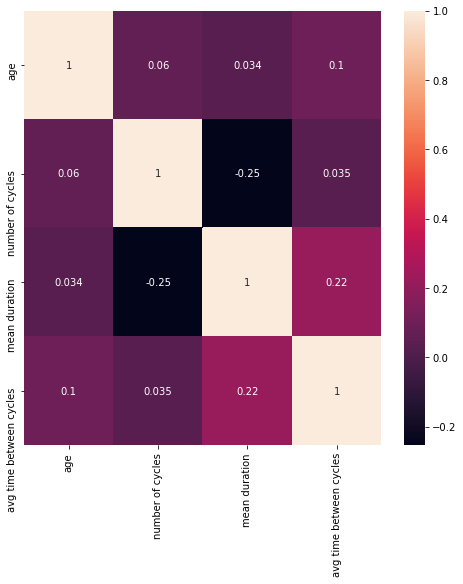

In [141]:
d=df[['age','number of cycles', 'mean duration','avg time between cycles']]
plt.figure(figsize=(8,8))
sns.heatmap(d.corr(), annot=True)
plt

From the correlation graph we can see that there is 22% positive correlation between mean duration of cyles and avg time between cycles. Also, there is a negative correlation of 25% between the number of cycles and mean duration of cycles, which is quite intuitive

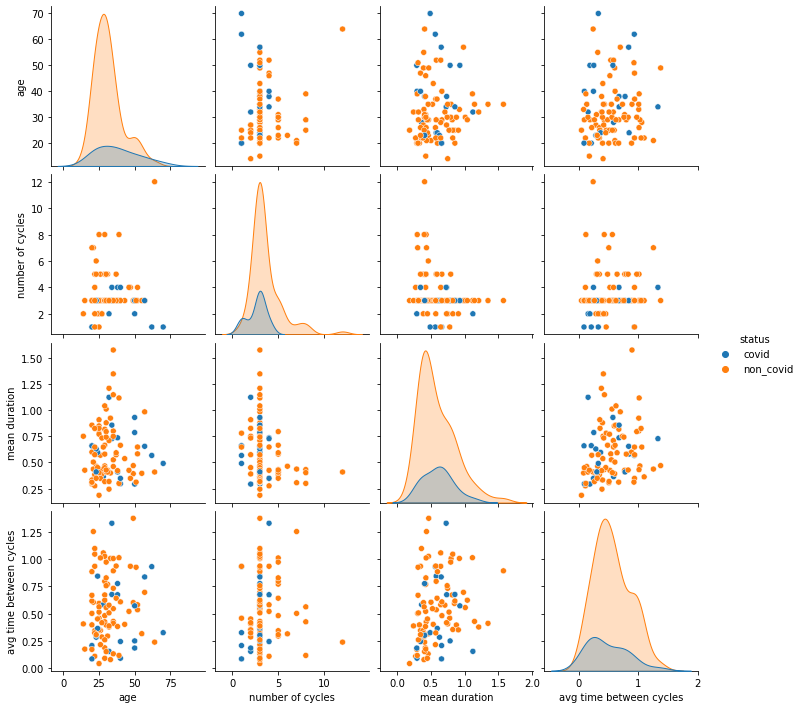

In [142]:
sns.pairplot(df, kind="scatter", hue ='status')

In [157]:
from scipy import stats
result = stats.ttest_rel(df['avg time between cycles'],df['mean duration'])
print(result)

Ttest_relResult(statistic=-1.3490843600577016, pvalue=0.18038741481237539)


A paired t-test is performed. The degree of freedom here is 99.The p-value associated with the t-score, is greater than 0.05 which implies the mean difference between the variables is not different from 0. The variables are statistically redundant whihc is also proved by a small t-score as they have also have a reasonable amount of correlation (22%) 

In [158]:
result = stats.ttest_rel(df['avg time between cycles'],df['number of cycles'])
print(result)

Ttest_relResult(statistic=-17.46913352274766, pvalue=5.26792739493255e-32)


A paired t-test is performed. The degree of freedom here is 99.The p-value associated with the t-score, is much lesser than 0.05 which implies the mean difference between the variables is ver much different from 0. The variables are statistically independent and relevent with very low correlation. 


In [169]:
result = stats.ttest_rel(df['mean duration'],df['number of cycles'])
print(result)

Ttest_relResult(statistic=-16.500089266458964, pvalue=3.5818387170350524e-30)


In [175]:
op1=['covid']
op2=['non_covid']
covid_d=df[df['status'].isin(op1)]['mean duration']
ncovid_d=df[df['status'].isin(op2)]['mean duration']
result = stats.ttest_ind(covid_d,ncovid_d)
print(result)

Ttest_indResult(statistic=0.22939968344720732, pvalue=0.8190363726412013)


Independent t-tests were performed for Covid and non-covid data over the mean-duration of cycles variables. A low t-score and high p-value of 0.82>>0.05, retains the null-hypothesis that both the groups for this variable have a similar statistical distribution.

In [176]:
op1=['covid']
op2=['non_covid']
covid_d=df[df['status'].isin(op1)]['avg time between cycles']
ncovid_d=df[df['status'].isin(op2)]['avg time between cycles']
result = stats.ttest_ind(covid_d,ncovid_d)
print(result)

Ttest_indResult(statistic=-0.9531910950188025, pvalue=0.34283842530419995)


Independent t-tests were performed for Covid and non-covid data over the mean-duration of cycles variables. A low t-score and high p-value of 0.34>>0.05, retains the null-hypothesis that both the groups for this variable have a similar statistical distribution. Probably the 100 files chosen out of more than 400 is giving these statistics. If done on a larger dataset, better values could be observed.